In [283]:
import glob, os, re, json, pickle
import pandas as pd
from classifier import *
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)

%reload_ext autoreload
%autoreload 2

<ipython-input-283-71a46c7e25ac>:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [284]:
df_human = pd.read_json('human_labeled_data.json')
df_human['text'] = df_human['text_data'].str.replace('https[^\s]*\s', '')
df_human['manifestolabel_true'] = df_human['major_label'].str.replace('\d\d\d ','')
# df_human['manifestolabel_true'] = df_human['manifestolabel_true'].replace('ignored','undefined')
df_human = df_human.drop(['text_data','labeled','major_label','selected','taught','labels','users','uncertainty','text_id','predicted_label'],axis=1)
# df_human.to_json('human_labeled_anonymized.json',orient='records')
df_human

,text,manifestolabel_true
0,Weltbeste Bildung! Jetzt! Weltbeste Bildung! Jetzt! Weltbeste Bildung! Jetzt! Weltbeste Bildung! Jetzt! Weltbeste Bildung! Jetzt! Weltbeste Bildung! Jetzt! Weltbeste Bildung! Jetzt! Weltbeste Bildung! Jetzt! Weltbeste Bildung! Jetzt! Weltbeste Bildung! Jetzt!,education +
1,"(2/2) Das TH in das sie gebracht wurde, ist knapp 50km entfernt. Leider wissen wir, wie dort hinter den Türen gearbeitet wird und sind sofort hingefahren, um sie da rauszuholen. Dafür mussten wir sie offiziell Adoptieren. Jetzt ist sie bei uns, wird gefüttert und gut versorgt!",environmentalism +
2,"„Heute gekaufte Autos produzieren über 15 Jahre klimagefährliche Emissionen, Stickoxid und Feinstaub. Wir schlagen uns heute mit den Folgen der letzten Abwrackprämie herum mit zu hohen Treibhausgas-, Feinstaub- und Stickoxidemissionen aus dem Straßenverkehr.“ @CKemfert",environmentalism +
3,"Wir brauchen eine Opposition. Das macht eine Demokratie aus. Ohne Diskussion gibt es keine Demokratie. Und: Ohne die Möglichkeit Kritik zu üben, auch nicht. Wenn jede Kritik, z.B. an der Migrationspolitik Nazi ist, dann läuft etwa falsch.",democracy +
4,"Rechtsstaat und Demokratie in Europa schützen! @katarinabarley und @RobertBiedron stemmen sich gemeinsam gegen die Justizreformen der nationalkonservativen PiS-Regierung in Warschau, die den Rechtsstaat zersetzen. #EU #Rechtsstaat #Demokratie #Polen #Ungarn",democracy +
...,...,...
1006,#MSLInsights-Session zur deutschen EU-Ratspräsidentschaft mit @KLeikert @cducsubt und den Moderatoren @walli5 und @wigansalazar,ignored
1007,Der gefährlichste Virus ist Rassismus! Es gibt NIE einen Grund für Rassismus und Diskriminierung! Das Coronavirus kann von allen Menschen übertragen werden. #Ichbinkeinvirus #jenesuispasunvirus #nosoyunvirus #iamnotavirus #coronavirus,social justice +
1008,"Windkraft schützt die Umwelt Windkraft schützt die Umwelt Windkraft schützt die Umwelt Windkraft schützt die Umwelt Windkraft schützt die Umwelt Und ist wichtiger Teil der @EEnergiewende Alles andere sind Lobbynews der Fossilatomaren Lobby, sind Mythen",environmentalism +
1009,Reich sind immer die oberen 10 Prozent. Bis nix mehr da ist.,free enterprise +


# Classifier trained on manifesto,  tested on tweets

In [285]:
dd = score_texts(df_human)
print(classification_report(dd['manifestolabel_true'],dd['manifestolabel']))

                        precision    recall  f1-score   support

                             0.00      0.00      0.00         0
         agriculture +       0.67      0.67      0.67        12
 anti-growth economy +       0.00      0.00      0.00        16
          centralism +       0.00      0.00      0.00         1
        constitution +       0.00      0.00      0.00         1
        constitution -       0.00      0.00      0.00         1
  controlled economy +       0.00      0.00      0.00         2
             culture +       0.54      0.88      0.67        17
        decentralism +       0.00      0.00      0.00         0
           democracy +       0.86      0.68      0.76       112
        economic goals       0.00      0.00      0.00         1
           education +       0.51      0.84      0.63        43
           education -       0.00      0.00      0.00         2
    environmentalism +       0.60      0.87      0.71       156
              europe +       0.61      

/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train and test on tweets only

In [314]:
df_manifesto = get_manifesto_data()
tweets_train, tweets_test, labels_train,  labels_test = train_test_split(df_human['text'], 
                                                                         df_human['manifestolabel_true'],
                                                                         test_size=.2)
df_manifesto = df_manifesto.sample(n=2000)
train_text = pd.concat([df_manifesto['text'],tweets_train])
train_labels = pd.concat([df_manifesto['manifestolabel'],labels_train]) 

# train_text = tweets_train
# train_labels = labels_train

enough_samples_per_class = train_labels.value_counts() > 10
valid = train_labels.isin(enough_samples_per_class[enough_samples_per_class==True].index)


train_single(train_text[valid], train_labels[valid], 'tweets_only')

df_test = pd.concat([tweets_test,labels_test],axis=1)
df_test.columns = ['text','manifestolabel_true']
tw = score_texts(df_test,['tweets_only'])
print(classification_report(tw['manifestolabel_true'],tw['tweets_only']))

Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.8s finished
/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

                             0.00      0.00      0.00         0
         agriculture +       0.00      0.00      0.00         3
 anti-growth economy +       0.00      0.00      0.00         4
             culture +       0.67      0.40      0.50         5
           democracy +       1.00      0.48      0.65        21
           education +       0.43      0.30      0.35        10
    environmentalism +       0.80      0.48      0.60        25
              europe +       0.00      0.00      0.00         1
              europe -       0.00      0.00      0.00         1
     foreign special +       0.00      0.00      0.00         3
     free enterprise +       0.00      0.00      0.00         3
freedom/human rights +       0.67      0.33      0.44        12
               ignored       0.67      0.07      0.12        30
          incentives +       0.00      0.00      0.00         1
      infrastructure +       0.00      

/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [252]:
train_text = pd.concat([df_manifesto['text'],df_human['text']])
train_labels = pd.concat([df_manifesto['manifestolabel'],
                          df_human['manifestolabel_true']]) 
train_single(train_text, train_labels, 'all_tweets')

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    5.6s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.0s finished
/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [253]:
# read all tweets and remove those that were labeled
df_tweets = pd.read_json('tweets_all.json.gzip',compression='gzip')
df_tweets['text'] = df_tweets['text'].fillna('')
df_tweets = df_tweets[df_tweets.text.isin(df_human['text']) == False]
df_tweets

,index,text,url,retweets,likes,replies,date,manifestolabel_keywords,id,quotes
0,0,Rede über Deine Vision und Ziele! Als viertes #Prinzip muss ein #Unternehmer #Manager seine #Mitarbeiter und sein Umfeld von der Realität seiner #Vision und #Ziele überzeugen. #Reden um #Begeisterung in den Menschen entfachen: https://www.wissen-agentur.de/w-zzb05.html,https://twitter.com/WISSENAgentur/status/1223029926003126273,0.0,0.0,0.0,2020-01-30 23:47:11,internationalism -,1.223030e+18,NaN
1,1,Ruff(us) Brevett Lassie Diarra Graham FENTON FENTON FEEENNNNTTTOOONN Wesley Schnauser,https://twitter.com/BarrowsMikeOtto/status/1223025959869218816,0.0,16.0,3.0,2020-01-30 23:31:26,internationalism -,1.223026e+18,NaN
2,2,"Mal ernsthaft diese Tweets in in denen ständig davon die Rede ist das es keinen Rassismus gegen weiße gibt regen mich sowas von auf. Nur weil es mehr weiße auf der Welt gibt, bedeutet es nicht das sie nicht trotzdem rassistisch behandelt werden können.",https://twitter.com/liam_witte/status/1223024892263784449,0.0,1.0,0.0,2020-01-30 23:27:11,internationalism -,1.223025e+18,NaN
3,3,Ich möchte gerne sie haben recht,https://twitter.com/Sara60603304/status/1223022275034742789,0.0,1.0,0.0,2020-01-30 23:16:47,internationalism -,1.223022e+18,NaN
4,4,"Sehr gerne - ich freue mich, wenn es hilft",https://twitter.com/katha_krentz/status/1223015670545371136,0.0,1.0,0.0,2020-01-30 22:50:33,internationalism -,1.223016e+18,NaN
...,...,...,...,...,...,...,...,...,...,...
851806,584564,@edanui @Nubss666 Ne ich meine von ihren eltern,https://twitter.com/qehaimniz/status/1335045964105723906,0.0,2.0,1.0,2020-12-05 02:18:56,traditional morality +,1.335046e+18,0.0
851807,584565,"@Karl_Lauterbach @KonstantinKuhle @fdp Hallo liebe Zahnfee, ass mal Deine Familie schön raus. Du Twitterst doch oder? Wenn ich was schreibe hat meine Familie damit auch nix am Hut. Die Tränendrüse kannst Du Dir sparen.",https://twitter.com/Think_Big_Q/status/1335045864977559552,0.0,0.0,0.0,2020-12-05 02:18:32,traditional morality +,1.335046e+18,0.0
851808,584566,DEINE ELTERN SIND GESCHWISTER @tanjirxxo #Splatoon2 #NintendoSwitch https://t.co/T86buGgV9n,https://twitter.com/Iana_spl/status/1335045842277830657,0.0,0.0,0.0,2020-12-05 02:18:27,traditional morality +,1.335046e+18,0.0
851809,596562,Kangen EXO bund :( https://t.co/GTJ4QuuKpU,https://twitter.com/kinokecil/status/1335046703997587456,0.0,1.0,0.0,2020-12-05 02:21:52,gov-admin efficiency +,1.335047e+18,0.0


In [198]:
df_scored = score_texts(df_tweets, label_types=['all_tweets'], min_precision=.3)
df_scored.reset_index().to_json('tweets_all_scored.json.gzip',compression='gzip')

In [246]:
df_scored = pd.read_json('tweets_all_scored.json.gzip',compression='gzip')
dates = pd.date_range('1/1/2020', periods=12, freq='M')
for i,d in enumerate(dates[:-1]):
    idx = (df_scored['date']>dates[i]) & (df_scored['date']<dates[i+1])
    tweets_per_month = len(df_scored[idx])
    print(f'{d}:{tweets_per_month}') 

2020-01-31 00:00:00:75567
2020-02-29 00:00:00:232031
2020-03-31 00:00:00:270150
2020-04-30 00:00:00:76265
2020-05-31 00:00:00:0
2020-06-30 00:00:00:0
2020-07-31 00:00:00:0
2020-08-31 00:00:00:0
2020-09-30 00:00:00:0
2020-10-31 00:00:00:34
2020-11-30 00:00:00:45182


In [241]:
df_scored['manifestolabel'] = df_scored['all_tweets']
above_length_idx = df_scored['text'].apply(len) > 50
low_precision = df_scored['all_tweets'] == ''
ignored = df_scored['all_tweets'] == 'ignored'
interacted_with = df_scored[['replies','retweets','likes']].sum(axis=1)>10
df_scored = df_scored[above_length_idx & interacted_with & ~ignored & ~low_precision]
df_scored['tweet_with_url'] = df_scored['url'] + " " + df_scored['text']
df_scored = df_scored.drop(['index','level_0','quotes','all_tweets_proba','all_tweets'],axis=1)
df_scored.to_json('tweets_with_url.json.gzip',compression='gzip')


In [243]:
df_scored['before'] = df_scored['date'] < pd.Timestamp(2020,3,15)


In [244]:
df_scored['before'].value_counts()

False    3307
True     2894
Name: before, dtype: int64

In [245]:
for i,d in enumerate(dates[:-1]):
    idx = (df_scored['date']>dates[i]) & (df_scored['date']<dates[i+1])
    tweets_per_month = len(df_scored[idx])
    print(f'{d}:{tweets_per_month}') 

2020-01-31 00:00:00:1031
2020-02-29 00:00:00:1380
2020-03-31 00:00:00:1374
2020-04-30 00:00:00:1067
2020-05-31 00:00:00:0
2020-06-30 00:00:00:0
2020-07-31 00:00:00:0
2020-08-31 00:00:00:0
2020-09-30 00:00:00:0
2020-10-31 00:00:00:2
2020-11-30 00:00:00:260


In [78]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)
above_precision_idx = df_scored['manifestolabel'] != ''
above_length_idx = df_scored['text'].apply(len) > 50
interacted_with = (df_scored['favorites'] > 10) | \
                    (df_scored['replies'] > 10) | \
                    (df_scored['retweets'] > 10)
valid = above_length_idx & above_precision_idx & interacted_with
df_scored.loc[valid,:].head(n=20)

<ipython-input-78-9967ece9758d>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,username,to,text,retweets,favorites,replies,id,permalink,author_id,formatted_date,...,geo,urls,url_text,manifestolabel_keywords,date,before,after,all_tweets_proba,all_tweets,manifestolabel
154,the_aeschli,None,Klima Umweltschutz Rechtsrutsch Korruption Hass und Hetze Bildung Armut Gesundheitskosten Krieg und Terror Und dann eines Morgens in der Schweiz: Fondue-Emoji,1.0,16.0,1.0,1222859159432986626,https://twitter.com/the_aeschli/status/1222859159432986626,4.293346e+08,Thu Jan 30 12:28:37 +0000 2020,...,,,,internationalism -,2020-01-30 12:28:37,True,False,0.316939,environmentalism +,environmentalism +
316,HMWK_Hessen,None,"Mit dem Haushalt 2020 stärken wir die Bedeutung von Wissenschaft und Kultur Ministerin @Angela_Dorn hat heute in ihrer Rede im @Landtag_Hessen betont, dass Wissenschaft und Kultur in bewegten Zeiten Leitlinien setzen und Denkanstöße bieten können.",5.0,19.0,0.0,1222582125758754819,https://twitter.com/HMWK_Hessen/status/1222582125758754819,1.105414e+18,Wed Jan 29 18:07:47 +0000 2020,...,,,,internationalism -,2020-01-29 18:07:47,True,False,0.324228,culture +,culture +
1503,FabianGramling,None,"Viele wollen mehr Frauen an der Spitze! Wir haben die richtige Spitzenkandidatin mit Susanne Eisenmann - mit Mut und Entschlossenheit die richtigen Entscheidungen treffen. Für uns, für ein starkes Baden-Württemberg! #Schöntal20 #cdu #ltw21 @CDU_BW @CDU_FraktionBW",2.0,12.0,0.0,1221001255071506432,https://twitter.com/FabianGramling/status/1221001255071506432,7.383583e+17,Sat Jan 25 09:25:58 +0000 2020,...,,,,internationalism -,2020-01-25 09:25:58,True,False,0.384000,political authority +,political authority +
2105,AutorToto,None,"„Dies ist eine Welt, in der Kraftmeier in Ländern wie #China und #Russland massiv aufrüsten, und #Europa sitzt herum und redet über Green Deals. Ich würde sagen: Hallo? Aufwachen!“ Niall #Ferguson https://www.welt.de/wirtschaft/plus205258763/Niall-Ferguson-Merkels-Kanzlerschaft-war-ein-kolossaler-Ausfall.html?wtmc=socialmedia.twitter.shared.web via @welt",33.0,79.0,11.0,1220133424951889922,https://twitter.com/AutorToto/status/1220133424951889922,1.613534e+08,Wed Jan 22 23:57:32 +0000 2020,...,,https://www.welt.de/wirtschaft/plus205258763/Niall-Ferguson-Merkels-Kanzlerschaft-war-ein-kolossaler-Ausfall.html?wtmc=socialmedia.twitter.shared.web,"„Ihr Deutschen halt“: Gar nicht richtig hätten die WELT-Reporter mit ihren Berichten und Tweets über den Auftritt von Donald Trump gelegen, sagt Niall Ferguson bei einem kurzen Zusammentreffen auf den Fluren des Kongresszentrums in Davos, feixend, aber nur halb im Scherz. Grund genug für die Verabredung zu einem ausführlicheren Interview am Rande des Weltwirtschaftsforums. Ferguson, der in Havard und an der Stanford University in Kalifornien lehrte, ist gebürtiger Schotte. Doch er hat sich, sagt er, vor nicht allzulanger Zeit, zusätzlich die amerikanische Staatsbürgerschaft zulegt. „Als Rückversicherung“, wie er sagt, wieder feixend, wieder nur halb im Scherz. WELT: Die Trump-Rede hier in Davos – fanden Sie die gut? Die WELT als ePaper: Die vollständige Ausgabe steht Ihnen bereits am Vorabend zur Verfügung – so sind Sie immer hochaktuell informiert. Weitere Informationen: http://epaper.welt.de Der Kurz-Link dieses Artikels lautet: https://www.welt.de/205258763",internationalism -,2020-01-22 23:57:32,True,False,0.300547,internationalism +,internationalism +
2477,markuspreiss,None,„China ist noch immer das größte Entwicklungsland der Welt.“ Sagt der Vize-Premier des Landes. Und auch das sieht beim #WEF20 sicher nicht jeder so. Stichwort: WTO und unterschiedliche Regeln für Industrie- und Entwicklungsländer.,1.0,12.0,4.0,1219613762463903744,https://twitter.com/markuspreiss/status/1219613762463903744,1.804760e+08,Tue Jan 21 13:32:34 +0000 2020,...,,,,internationalism -,2020-01-21 13:32:34,True,False,0.384367,internationalism +,internationalism +
3013,EberleSebastian,hannahuenniger,"Ich unterstelle mal, die Kollegin hat keine Ahnung, wie sich Krieg „anfühlt“. Im 

In [79]:
df_scored.loc[valid,:]

,username,to,text,retweets,favorites,replies,id,permalink,author_id,formatted_date,...,geo,urls,url_text,manifestolabel_keywords,date,before,after,all_tweets_proba,all_tweets,manifestolabel
154,the_aeschli,None,Klima Umweltschutz Rechtsrutsch Korruption Hass und Hetze Bildung Armut Gesundheitskosten Krieg und Terror Und dann eines Morgens in der Schweiz: Fondue-Emoji,1.0,16.0,1.0,1222859159432986626,https://twitter.com/the_aeschli/status/1222859159432986626,4.293346e+08,Thu Jan 30 12:28:37 +0000 2020,...,,,,internationalism -,2020-01-30 12:28:37,True,False,0.316939,environmentalism +,environmentalism +
316,HMWK_Hessen,None,"Mit dem Haushalt 2020 stärken wir die Bedeutung von Wissenschaft und Kultur Ministerin @Angela_Dorn hat heute in ihrer Rede im @Landtag_Hessen betont, dass Wissenschaft und Kultur in bewegten Zeiten Leitlinien setzen und Denkanstöße bieten können.",5.0,19.0,0.0,1222582125758754819,https://twitter.com/HMWK_Hessen/status/1222582125758754819,1.105414e+18,Wed Jan 29 18:07:47 +0000 2020,...,,,,internationalism -,2020-01-29 18:07:47,True,False,0.324228,culture +,culture +
1503,FabianGramling,None,"Viele wollen mehr Frauen an der Spitze! Wir haben die richtige Spitzenkandidatin mit Susanne Eisenmann - mit Mut und Entschlossenheit die richtigen Entscheidungen treffen. Für uns, für ein starkes Baden-Württemberg! #Schöntal20 #cdu #ltw21 @CDU_BW @CDU_FraktionBW",2.0,12.0,0.0,1221001255071506432,https://twitter.com/FabianGramling/status/1221001255071506432,7.383583e+17,Sat Jan 25 09:25:58 +0000 2020,...,,,,internationalism -,2020-01-25 09:25:58,True,False,0.384000,political authority +,political authority +
2105,AutorToto,None,"„Dies ist eine Welt, in der Kraftmeier in Ländern wie #China und #Russland massiv aufrüsten, und #Europa sitzt herum und redet über Green Deals. Ich würde sagen: Hallo? Aufwachen!“ Niall #Ferguson https://www.welt.de/wirtschaft/plus205258763/Niall-Ferguson-Merkels-Kanzlerschaft-war-ein-kolossaler-Ausfall.html?wtmc=socialmedia.twitter.shared.web via @welt",33.0,79.0,11.0,1220133424951889922,https://twitter.com/AutorToto/status/1220133424951889922,1.613534e+08,Wed Jan 22 23:57:32 +0000 2020,...,,https://www.welt.de/wirtschaft/plus205258763/Niall-Ferguson-Merkels-Kanzlerschaft-war-ein-kolossaler-Ausfall.html?wtmc=socialmedia.twitter.shared.web,"„Ihr Deutschen halt“: Gar nicht richtig hätten die WELT-Reporter mit ihren Berichten und Tweets über den Auftritt von Donald Trump gelegen, sagt Niall Ferguson bei einem kurzen Zusammentreffen auf den Fluren des Kongresszentrums in Davos, feixend, aber nur halb im Scherz. Grund genug für die Verabredung zu einem ausführlicheren Interview am Rande des Weltwirtschaftsforums. Ferguson, der in Havard und an der Stanford University in Kalifornien lehrte, ist gebürtiger Schotte. Doch er hat sich, sagt er, vor nicht allzulanger Zeit, zusätzlich die amerikanische Staatsbürgerschaft zulegt. „Als Rückversicherung“, wie er sagt, wieder feixend, wieder nur halb im Scherz. WELT: Die Trump-Rede hier in Davos – fanden Sie die gut? Die WELT als ePaper: Die vollständige Ausgabe steht Ihnen bereits am Vorabend zur Verfügung – so sind Sie immer hochaktuell informiert. Weitere Informationen: http://epaper.welt.de Der Kurz-Link dieses Artikels lautet: https://www.welt.de/205258763",internationalism -,2020-01-22 23:57:32,True,False,0.300547,internationalism +,internationalism +
2477,markuspreiss,None,„China ist noch immer das größte Entwicklungsland der Welt.“ Sagt der Vize-Premier des Landes. Und auch das sieht beim #WEF20 sicher nicht jeder so. Stichwort: WTO und unterschiedliche Regeln für Industrie- und Entwicklungsländer.,1.0,12.0,4.0,1219613762463903744,https://twitter.com/markuspreiss/status/1219613762463903744,1.804760e+08,Tue Jan 21 13:32:34 +0000 2020,...,,,,internationalism -,2020-01-21 13:32:34,True,False,0.384367,internationalism +,internationalism +
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263932,reitschuster,NaN,"Die W

In [80]:
df_scored['tweet_with_url'] = df_scored['permalink'] + " " + df_scored['text']
df_scored.loc[valid,['tweet_with_url']]
# ?df_scored.loc[valid & (df_scored['urls']),['text','urls']]

,tweet_with_url
154,https://twitter.com/the_aeschli/status/1222859159432986626 Klima Umweltschutz Rechtsrutsch Korruption Hass und Hetze Bildung Armut Gesundheitskosten Krieg und Terror Und dann eines Morgens in der Schweiz: Fondue-Emoji
316,"https://twitter.com/HMWK_Hessen/status/1222582125758754819 Mit dem Haushalt 2020 stärken wir die Bedeutung von Wissenschaft und Kultur Ministerin @Angela_Dorn hat heute in ihrer Rede im @Landtag_Hessen betont, dass Wissenschaft und Kultur in bewegten Zeiten Leitlinien setzen und Denkanstöße bieten können."
1503,"https://twitter.com/FabianGramling/status/1221001255071506432 Viele wollen mehr Frauen an der Spitze! Wir haben die richtige Spitzenkandidatin mit Susanne Eisenmann - mit Mut und Entschlossenheit die richtigen Entscheidungen treffen. Für uns, für ein starkes Baden-Württemberg! #Schöntal20 #cdu #ltw21 @CDU_BW @CDU_FraktionBW"
2105,"https://twitter.com/AutorToto/status/1220133424951889922 „Dies ist eine Welt, in der Kraftmeier in Ländern wie #China und #Russland massiv aufrüsten, und #Europa sitzt herum und redet über Green Deals. Ich würde sagen: Hallo? Aufwachen!“ Niall #Ferguson https://www.welt.de/wirtschaft/plus205258763/Niall-Ferguson-Merkels-Kanzlerschaft-war-ein-kolossaler-Ausfall.html?wtmc=socialmedia.twitter.shared.web via @welt"
2477,https://twitter.com/markuspreiss/status/1219613762463903744 „China ist noch immer das größte Entwicklungsland der Welt.“ Sagt der Vize-Premier des Landes. Und auch das sieht beim #WEF20 sicher nicht jeder so. Stichwort: WTO und unterschiedliche Regeln für Industrie- und Entwicklungsländer.
...,...
263932,"https://twitter.com/reitschuster/status/1225049612353970178 Die Wahl von #Kemmerich in #Thüringen sprengt Risse in die politische Grabplatte, die Merkel &amp; Co. auf unsere Politik gelegt haben. Ihre „Alternativlosigkeits“-Strategie droht zu scheitern. Der Aufschrei ist so gewaltig, weil Linksgrün jetzt um seine Hegemonie fürchten muss."
264884,"https://twitter.com/TheBerlinLive/status/1249211170562678789 ich wünsche allen ein schönes #Osterfest auch wenn es dieses Jahr anders verläuft als sonst, wir müssen durchhalten auch wenn's schwer fällt macht das beste draus #OsternAndersErleben #wirbleibenzuhaus #FlattenTheCuve und #AbstandHalten beim #Spaziergang"
266032,https://twitter.com/Vel0Le/status/1246740517708353539 Jedes Jahr das gleiche: 14°C — lang oder kurz? #Rennrad
266444,"https://twitter.com/m0ndin0/status/1245790547555635207 das jahr ist eh so reingeschissen, dass lijana doch perfekt #GNTM 2020 werden sollte perfektes symbolbild für 2020"


In [81]:
df_scored.loc[valid,['tweet_with_url']].reset_index().to_json('tweets_with_permalink.json')

In [82]:
df_scored.loc[valid, 'manifestolabel'].value_counts()

political authority +     1009
environmentalism +        900 
social justice +          770 
democracy +               324 
freedom/human rights +    198 
education +               181 
infrastructure +          154 
europe +                  101 
welfare +                 93  
labour +                  83  
market regulation +       70  
law and order +           63  
culture +                 50  
non economic groups +     45  
military -                28  
internationalism +        27  
military +                26  
agriculture +             26  
social harmony +          25  
traditional morality +    17  
gov-admin efficiency +    17  
minority groups +         11  
anti-growth economy +     11  
decentralism +            10  
peace +                   9   
economic orthodoxy +      7   
economic goals            6   
national way of life +    5   
traditional morality -    4   
foreign special +         4   
incentives +              3   
productivity +            3   
free ent

In [83]:
df_scored.loc[valid, 'before'].value_counts()

False    2149
True     2137
Name: before, dtype: int64

In [84]:
((df_scored.loc[valid & df_scored['after'],'manifestolabel_keywords'].value_counts() / df_scored.loc[valid & df_scored['before'],'manifestolabel_keywords'].value_counts()).sort_values()).dropna()

democracy +               0.098039
free enterprise +         0.166667
constitution -            0.333333
political authority +     0.398190
protectionism +           0.500000
political corruption -    0.500000
incentives +              0.500000
foreign special +         0.500000
education -               0.500000
education +               0.500000
internationalism -        0.526946
national way of life -    0.550173
welfare -                 0.562500
culture +                 0.571429
internationalism +        0.655914
marxist analysis +        0.666667
protectionism -           0.666667
europe +                  0.700000
labour -                  0.714286
infrastructure +          0.728814
national way of life +    0.733333
foreign special -         0.750000
social justice +          0.797101
peace +                   0.840336
market regulation +       0.875000
law and order +           0.941176
traditional morality -    0.957317
economic planning +       1.000000
minority groups +   

In [85]:
from sklearn.feature_extraction.text import CountVectorizer
stopwords = [x.strip() for x in open('stopwords.txt').readlines()[7:]]
vect = CountVectorizer(stop_words=stopwords).fit(df_scored['text'])
before_words = vect.transform(df_scored.loc[df_scored['before'],'text'])
after_words = vect.transform(df_scored.loc[df_scored['after'],'text'])

/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bsp', 'ca', 'hen', 'kurgan', 'matveev', 'solc'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [86]:
import numpy as np
keywords = pd.read_csv('keywords.csv')
all_keywords = pd.Series(keywords.values.flatten()).dropna().to_list()
idx2word = {v:k for k,v in vect.vocabulary_.items()}

In [87]:
before = np.array(before_words.sum(axis=0)) + 1
before = before / before.max()
after = np.array(after_words.sum(axis=0)) + 1
after = after / after.max()
increase = (after / before).flatten()
inc_idx = [idx for idx in increase.argsort() if idx2word[idx] in all_keywords]

In [88]:
top = 1000
most_increase = {idx2word[i]:increase[i] for i in inc_idx[-top:-1:] }
least_increase = {idx2word[i]:increase[i] for i in inc_idx[:top]}
# print(most_increase)
# print(least_increase)
pd.Series(most_increase).to_csv('increased.csv')
pd.Series(least_increase).to_csv('decreased.csv')

In [89]:
pd.Series(keywords.values.flatten()).dropna()

0       landwirtschaft 
1       nachhaltigkeit 
2       gottfried      
3       bund           
4       grundgesetz    
           ...         
1115    frau           
1116    kitas          
1117    eheschließung  
1118    wohngeld       
1119    übersichtlichen
Length: 1119, dtype: object

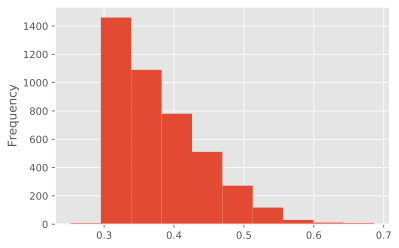

In [91]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df_scored.loc[valid,'all_tweets_proba'].plot.hist()

In [92]:
# df_scored.loc[valid,'domain_proba'].plot.hist()

KeyError: 'domain_proba'

In [ ]:
plt.figure(figsize=[5,15]);
ddd = pd.DataFrame(
    [df_scored.loc[valid & df_scored['after'],'manifestolabel'].value_counts(normalize=True), 
     df_scored.loc[valid & df_scored['before'],'manifestolabel'].value_counts(normalize=True)],
    index=['after','before']).T

ddd[abs(ddd['after'] / ddd['before'] - 1) > .1].plot.barh()

plt.ylim([-1,15.5])
plt.title('Manifestolabels')
plt.xlabel('# Predictions')
plt.tight_layout()
plt.savefig('manifestolabels_before_after.pdf')

<Figure size 360x1080 with 0 Axes>

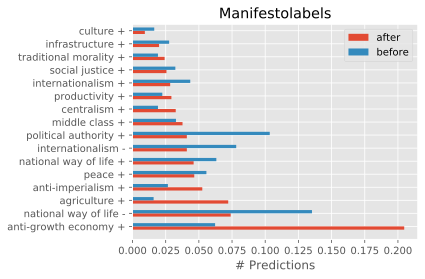

In [71]:
plt.figure(figsize=[5,15])

ddd = pd.DataFrame(
    [df_scored.loc[valid & df_scored['after'],'manifestolabel_keywords'].value_counts(normalize=True), 
     df_scored.loc[valid & df_scored['before'],'manifestolabel_keywords'].value_counts(normalize=True)],
    index=['after','before']).T

ddd[abs(ddd['after'] / ddd['before'] - 1) > .1].plot.barh()


plt.ylim([-1,15.5])
plt.title('Manifestolabels')
plt.xlabel('# Predictions')
plt.tight_layout()
plt.savefig('manifestolabels_before_after_keywords.pdf')

In [72]:
ddd = pd.DataFrame(
    [df_scored.loc[valid & df_scored['after'],'domain'].value_counts(normalize=True), 
     df_scored.loc[valid & df_scored['before'],'domain'].value_counts(normalize=True)],
    index=['after','before']).T

ddd[abs(ddd['after'] / ddd['before'] - 1) > .01].plot.barh()



plt.title('Political Domains')
plt.xlabel('# Predictions')
plt.tight_layout()
plt.savefig('domains_before_after.pdf')

KeyError: 'domain'

In [73]:
pd.DataFrame(
    [df_scored.loc[valid & df_scored['after'],'rightleft'].value_counts(normalize=True), 
     df_scored.loc[valid & df_scored['before'],'rightleft'].value_counts(normalize=True)],
    index=['before','after']).T.plot.bar()


KeyError: 'rightleft'

In [74]:
from classifier import get_manifesto_data
df = get_manifesto_data()
df

Loading manifesto/manifesto-Germany.csv


,text,manifestocodes,domain,rightleft,manifestolabel
0,Es ist Zeit für einen Wechsel,0,None,None,undefined
1,"Die Bundesrepublik braucht eine neue, eine soziale und ökologische Politik",303,Political System,None,gov-admin efficiency +
2,Die Herausforderungen eines neuen Jahrhunderts sind nicht mit den Konzepten von gestern und vorgestern zu bewältigen,303,Political System,None,gov-admin efficiency +
3,Politik kann nicht alle Probleme lösen,0,None,None,undefined
4,Aber Politik muß ihren Teil zur Lösung der Probleme beitragen,0,None,None,undefined
...,...,...,...,...,...
48471,Deutschland braucht qualifizierte und integrationswillige Zuwanderung.,608,Fabric of Society,None,multiculturalism -
48472,• Wir fordern ein Einwanderungsgesetz nach kanadischem Vorbild.,607,Fabric of Society,None,multiculturalism +
48473,Eine ungeordnete Zuwanderung in unsere Sozialsysteme muss unbedingt unterbunden werden.,601,Fabric of Society,right,national way of life +
48474,• Ernsthaft politisch Verfolgte müssen in Deutschland Asyl finden können.,201,Freedom and Democracy,right,freedom/human rights +


In [75]:
from classifier import get_manifesto_data
df = get_manifesto_data()
df['manifestolabel'] = df['manifestocodes'].astype('str') + " " + df['manifestolabel']
# df[['text','manifestolabel']]
df[['text','manifestolabel']].to_json('manifestodata.json')

Loading manifesto/manifesto-Germany.csv


In [146]:
from datetime import datetime
df_keywords = pd.read_csv('keywords.csv')
maxTweets = 1000
save_dir='tweets'
dates = pd.date_range('1/1/2020', periods=12, freq='M')

for week_idx, date in enumerate(dates):
    for label in df_keywords.columns:
        keywords = df_keywords[label]
        ss = label.replace('/','-')
        savestr = os.path.join(save_dir,f'{ss}-{date}.json')
        start = f'{dates[week_idx]}'[:10]
        stop = f'{dates[week_idx+1]}'[:10]
        print(f'{datestr}: Fetching tweets in range {start} - {stop} for keywords: {keywords}')

        tweets = []
        query = " OR ".join(keywords) + " lang:de" + ' since:' + start + "until:" + stop
        # Using TwitterSearchScraper to scrape data and append tweets to list
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
            if i>maxTweets:
                break
            tweets.append(tweet.__dict__)


        print(f'Found {len(tweets)} tweets')
        if len(tweets)>0:
            pd.DataFrame(tweets).to_json(savestr, orient='records', lines=True)
#except:

2020-12-05-00-39-47: Fetching tweets in range 2020-01-31 - 2020-02-29 for keywords: 0     landwirtschaft         
1     landwirte              
2     bauern                 
3     agrarpolitik           
4     ernährungswirtschaft   
5     landwirtschaftlichen   
6     forstwirtschaft        
7     kulturlandschaft       
8     bäuerinnen             
9     landwirtschaftliche    
10    landwirten             
11    bäuerlichen            
12    bäuerliche             
13    landwirtinnen          
14    kulturlandschaftsprämie
15    ländlichen             
16    betriebe               
17    multifunktionalen      
18    räume                  
19    landwirt               
Name: agriculture +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-01-31 - 2020-02-29 for keywords: 0     nachhaltige        
1     ökologische        
2     nachhaltigkeit     
3     nachhaltiges       
4     nachhaltigen       
5     ökologischen       
6     ökologisch       

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-01-31 - 2020-02-29 for keywords: 0     stadtumbau              
1     ost                     
2     solidarpakt             
3     west                    
4     programm                
5     wohnungsmärkte          
6     ii                      
7     stadt                   
8     planungssicherheit      
9     aufbau                  
10    bahnhofsmodernisierung  
11    programme               
12    strategie               
13    städtebauliche          
14    strukturschwäche        
15    hightech                
16    städtebauförderung      
17    beispielloses           
18    investitionszulagensätze
19    wohnqualität            
Name: economic planning +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-01-31 - 2020-02-29 for keywords: 0     bildung              
1     hochschulen          
2     schulen              
3     studierenden         
4     schule           

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-01-31 - 2020-02-29 for keywords: 0     forschung              
1     infrastruktur          
2     weiterbildung          
3     technologien           
4     mobilität              
5     ausbildung             
6     innovation             
7     innovationen           
8     verkehr                
9     ausbau                 
10    entwicklung            
11    verkehrsinfrastruktur  
12    bahn                   
13    schiene                
14    berufsausbildung       
15    forschungseinrichtungen
16    investitionen          
17    öpnv                   
18    berufliche             
19    duale                  
Name: infrastructure +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-01-31 - 2020-02-29 for keywords: 0     nationen                  
1     vereinten                 
2     internationalen           
3     internationale            
4     entwicklungszusammen

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-01-31 - 2020-02-29 for keywords: 0     behinderungen            
1     migrantinnen             
2     opfer                    
3     migranten                
4     behinderte               
5     behinderung              
6     behinderten              
7     barrierefreiheit         
8     flüchtlinge              
9     behinderter              
10    minderheiten             
11    leben                    
12    behindertenpolitik       
13    integration              
14    lesben                   
15    barrierefrei             
16    schwule                  
17    hilfe                    
18    migrationshintergrund    
19    selbstvertretungsanspruch
Name: minority groups +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-01-31 - 2020-02-29 for keywords: 0     einwanderungsland    
1     integration          
2     vielfalt             
3     einbürgerung         
4    

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-01-31 - 2020-02-29 for keywords: 0     engagement          
1     bürgerschaftliches  
2     solidarität         
3     ehrenamt            
4     zusammenhalt        
5     ehrenamtliche       
6     gesellschaft        
7     zivilgesellschaft   
8     engagements         
9     ehrenamtliches      
10    engagieren          
11    freiwilligendienste 
12    ehrenamtlich        
13    bürgerschaftlichen  
14    vereinen            
15    bürgergesellschaft  
16    freiwilligen        
17    freiwilligendiensten
18    ehrenamtlichen      
19    initiativen         
Name: social harmony +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-01-31 - 2020-02-29 for keywords: 0     frauen            
1     gerechtigkeit     
2     teilhabe          
3     einkommen         
4     männern           
5     männer            
6     gleiche           
7     diskriminierung   
8     herkunft    

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-02-29 - 2020-03-31 for keywords: 0     mindestlohn          
1     gesetzlichen         
2     flächendeckenden     
3     vergleichsmiete      
4     mindestlohns         
5     ortsüblichen         
6     auftragnehmern       
7     französischem        
8     mieterhöhungen       
9     vorschreibt          
10    gesetzlicher         
11    stunde               
12    euro                 
13    bestandswohnungen    
14    mindestlohnkommission
15    wiedervermietungen   
16    lohnspirale          
17    maximal              
18    vorzuschieben        
19    angespannten         
Name: controlled economy +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-02-29 - 2020-03-31 for keywords: 0     arbeitgebern        
1     sozialpartnerschaft 
2     gewerkschaften      
3     tarifautonomie      
4     sozialpartnern      
5     tarifparteien       
6     arbeitnehmern       
7    

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-02-29 - 2020-03-31 for keywords: 0     russland            
1     partnerschaft       
2     beziehungen         
3     transatlantische    
4     transatlantischen   
5     amerika             
6     israel              
7     israels             
8     nehmender           
9     widerlichkeit       
10    grundkonstante      
11    staatsräson         
12    stottert            
13    deutsch             
14    verantwortlicher    
15    russlands           
16    enge                
17    partnerschafts      
18    partner             
19    kooperationsabkommen
Name: foreign special +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-02-29 - 2020-03-31 for keywords: 0     raketenstationierungen
1     wiederaufflackern     
2     vereinnahmung         
3     hegemonialer          
4     stützpunkte           
5     oppositionellen       
6     auftretende           
7     bestrebu

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-02-29 - 2020-03-31 for keywords: 0     kriminalität       
1     polizei            
2     gewalt             
3     straftaten         
4     bekämpfen          
5     steuerhinterziehung
6     bekämpfung         
7     sicherheit         
8     justiz             
9     täter              
10    terrorismus        
11    organisierte       
12    sicherheitsbehörden
13    illegale           
14    kampf              
15    strafverfolgung    
16    verbrechen         
17    jugendkriminalität 
18    extremismus        
19    schutz             
Name: law and order +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-02-29 - 2020-03-31 for keywords: 0     verbraucher       
1     verbraucherinnen  
2     marktwirtschaft   
3     wettbewerb        
4     banken            
5     verbraucherschutz 
6     finanzmärkte      
7     unternehmen       
8     regeln            
9     lebensmi

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-02-29 - 2020-03-31 for keywords: 0     frauen       
1     kinder       
2     ältere       
3     jugendliche  
4     junge        
5     kindern      
6     gewalt       
7     mädchen      
8     jugendpolitik
9     älteren      
10    jugendlichen 
11    älterer      
12    alter        
13    jungen       
14    generationen 
15    männer       
16    generation   
17    frauenhäusern
18    frauenhäuser 
19    eigenständige
Name: non economic groups +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-02-29 - 2020-03-31 for keywords: 0     frieden               
1     friedenspolitik       
2     krisenprävention      
3     zivile                
4     zivilen               
5     friedens              
6     konfliktbearbeitung   
7     friedensdienst        
8     konflikte             
9     konfliktprävention    
10    konfliktforschung     
11    nahen                 
12   

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-02-29 - 2020-03-31 for keywords: 0     vorsorge          
1     private           
2     eigenverantwortung
3     altersvorsorge    
4     betriebliche      
5     rentenversicherung
6     eigenvorsorge     
7     kapitalgedeckte   
8     alterssicherung   
9     kapitaldeckung    
10    rente             
11    kapitalgedeckten  
12    gesetzlichen      
13    altersversorgung  
14    betriebsrenten    
15    privaten          
16    arbeitslosengeld  
17    betrieblichen     
18    gesetzliche       
19    alter             
Name: welfare -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-03-31 - 2020-04-30 for keywords: 0     landwirtschaft         
1     landwirte              
2     bauern                 
3     agrarpolitik           
4     ernährungswirtschaft   
5     landwirtschaftlichen   
6     forstwirtschaft        
7     kulturlandschaft       
8     bäuerinnen         

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-03-31 - 2020-04-30 for keywords: 0     schulden               
1     haushalte              
2     konsolidierung         
3     neuverschuldung        
4     euro                   
5     solide                 
6     schuldenbremse         
7     finanzen               
8     währung                
9     haushaltskonsolidierung
10    staatsfinanzen         
11    milliarden             
12    stabile                
13    bundeshaushalt         
14    verschuldung           
15    einnahmen              
16    ausgaben               
17    schuldenabbau          
18    finanzpolitik          
19    haushaltspolitik       
Name: economic orthodoxy +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-03-31 - 2020-04-30 for keywords: 0     stadtumbau              
1     ost                     
2     solidarpakt             
3     west                    
4     programm                

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-03-31 - 2020-04-30 for keywords: 0     unternehmen         
1     mittelstand         
2     kleine              
3     existenzgründer     
4     wagniskapital       
5     mittelständische    
6     mittlere            
7     mittleren           
8     rahmenbedingungen   
9     handwerk            
10    existenzgründungen  
11    existenzgründerinnen
12    betriebe            
13    investoren          
14    capital             
15    erp                 
16    venture             
17    mittelständischen   
18    förderung           
19    fördern             
Name: incentives +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-03-31 - 2020-04-30 for keywords: 0     forschung              
1     infrastruktur          
2     weiterbildung          
3     technologien           
4     mobilität              
5     ausbildung             
6     innovation             
7     innova

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-03-31 - 2020-04-30 for keywords: 0     abrüstung               
1     atomwaffen              
2     bundeswehr              
3     rüstungskontrolle       
4     wehrpflicht             
5     militärischen           
6     massenvernichtungswaffen
7     rüstungsexporte         
8     nato                    
9     waffen                  
10    militärische            
11    nuklearen               
12    abzug                   
13    nichtverbreitung        
14    nukleare                
15    militärischer           
16    krieg                   
17    konventionellen         
18    landminen               
19    zivile                  
Name: military -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-03-31 - 2020-04-30 for keywords: 0     behinderungen            
1     migrantinnen             
2     opfer                    
3     migranten                
4     behinderte

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-03-31 - 2020-04-30 for keywords: 0     handelshemmnisse         
1     exportsubventionen       
2     doha                     
3     abschottung              
4     anbaugebieten            
5     märkte                   
6     protektionismus          
7     wto                      
8     hauptexportprodukten     
9     handelsbarrieren         
10    welthandel               
11    entwicklungsländer       
12    degradieren              
13    marktöffnung             
14    rascher                  
15    runde                    
16    verhandlungen            
17    entwicklungsländern      
18    fortgang                 
19    investitionspartnerschaft
Name: protectionism -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-03-31 - 2020-04-30 for keywords: 0     engagement          
1     bürgerschaftliches  
2     solidarität         
3     ehrenamt            
4     zusam

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-04-30 - 2020-05-31 for keywords: 0     grundgesetz           
1     kinderrechte          
2     gg                    
3     absätze               
4     staatsziel            
5     gleichheitsrechte     
6     verankern             
7     geldwertwertstabilität
8     abs                   
9     kooperationsverbots   
10    fernmeldegeheimnis    
11    halbteilungsgrundsatz 
12    art                   
13    lauschangriffs        
14    landesverfassungen    
15    briefgeheimnis        
16    bundesfinanzhilfen    
17    klausel               
18    streichung            
19    antifaschistische     
Name: constitution -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-04-30 - 2020-05-31 for keywords: 0     mindestlohn          
1     gesetzlichen         
2     flächendeckenden     
3     vergleichsmiete      
4     mindestlohns         
5     ortsüblichen         
6     auftra

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-04-30 - 2020-05-31 for keywords: 0     europäische         
1     europa              
2     eu                  
3     europäischen        
4     union               
5     mitgliedstaaten     
6     europas             
7     kommission          
8     gemeinsame          
9     gemeinsamen         
10    europäischer        
11    ratspräsidentschaft 
12    staaten             
13    frankreich          
14    vertrag             
15    europäer            
16    ebene               
17    verteidigungspolitik
18    parlament           
19    währungsunion       
Name: europe +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-04-30 - 2020-05-31 for keywords: 0     eu                          
1     mitgliedstaaten             
2     union                       
3     europäischen                
4     europäische                 
5     grenzschutzagentur          
6     frontex   

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-04-30 - 2020-05-31 for keywords: 0     arbeit            
1     beschäftigten     
2     arbeitnehmer      
3     arbeitsbedingungen
4     arbeitnehmerinnen 
5     arbeitsplätze     
6     löhne             
7     beschäftigung     
8     arbeitszeit       
9     arbeitsmarkt      
10    arbeitszeiten     
11    beschäftigte      
12    arbeitslosigkeit  
13    gewerkschaften    
14    leiharbeit        
15    tarifverträge     
16    minijobs          
17    arbeitsplatz      
18    jobs              
19    betriebsräte      
Name: labour +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-04-30 - 2020-05-31 for keywords: 0     drittelparität          
1     vorstandsentscheidungen 
2     gewerkschaftsvertretern 
3     abfindungsregelungen    
4     arbeitsgerichtsprozessen
5     einstellungshemmnis     
6     beschäftigungsdauer     
7     aufsichtsrat            
8     gewerkschaft

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-04-30 - 2020-05-31 for keywords: 0     npd                 
1     rechtsextremismus   
2     antisemitismus      
3     rassismus           
4     nationalismus       
5     verbotsverfahren    
6     fremdenhass         
7     allheilmittel       
8     verbot              
9     ns                  
10    neofaschistischen   
11    nazistrukturen      
12    opferrechter        
13    fremdenfeindlichkeit
14    wachsame            
15    kampf               
16    anschlussförderungen
17    beobachtungsstelle  
18    rassisch            
19    bundesprogramme     
Name: national way of life -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-04-30 - 2020-05-31 for keywords: 0     privatisierung          
1     daseinsvorsorge         
2     hand                    
3     eigentum                
4     öffentliche             
5     öffentlicher            
6     wasserversorgung    

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-04-30 - 2020-05-31 for keywords: 0     lebensgemeinschaften 
1     lebenspartnerschaften
2     füreinander          
3     gleichgeschlechtliche
4     paare                
5     cannabis             
6     ehen                 
7     drogen               
8     eingetragene         
9     patchwork            
10    eingetragenen        
11    ehegattensplitting   
12    adoptionsrecht       
13    abgabeform           
14    individualbesteuerung
15    regenbogenfamilien   
16    lebenspartnerschaft  
17    jugendschutzes       
18    adoptiv              
19    pflegeeltern         
Name: traditional morality -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-04-30 - 2020-05-31 for keywords: 0     versorgung          
1     grundsicherung      
2     pflege              
3     rente               
4     leistungen          
5     rentenversicherung  
6     kindergeld          
7  

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-05-31 - 2020-06-30 for keywords: 0     demokratie       
1     demokratische    
2     bürgerinnen      
3     parlament        
4     demokratischen   
5     bürger           
6     bundestag        
7     kontrolle        
8     beteiligung      
9     demokratisch     
10    entscheidungen   
11    transparenz      
12    bürgerbeteiligung
13    mitbestimmung    
14    parlamente       
15    wahlrecht        
16    demokratischer   
17    parteien         
18    demokratisierung 
19    afd              
Name: democracy +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-05-31 - 2020-06-30 for keywords: 0     arbeitsplätze        
1     beschäftigung        
2     wettbewerbsfähigkeit 
3     räume                
4     ländlichen           
5     arbeit               
6     regionen             
7     ostdeutschland       
8     ländliche            
9     wirtschaftsstruktur  
10 

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-05-31 - 2020-06-30 for keywords: 0     menschenrechte         
1     freiheit               
2     daten                  
3     bürgerrechte           
4     datenschutz            
5     selbstbestimmung       
6     grundrechte            
7     recht                  
8     überwachung            
9     menschenwürde          
10    asyl                   
11    vorratsdatenspeicherung
12    schutz                 
13    rechte                 
14    informationelle        
15    menschenrechten        
16    grundrecht             
17    meinungsfreiheit       
18    bürger                 
19    privatsphäre           
Name: freedom/human rights +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-05-31 - 2020-06-30 for keywords: 0     bürokratie           
1     verwaltung           
2     vereinfachung        
3     effizienz            
4     reform               
5     verein

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-05-31 - 2020-06-30 for keywords: 0     mittelstand          
1     mitte                
2     rückgrat             
3     berufe               
4     handwerk             
5     gesundheitshandwerker
6     geisteshaltung       
7     patientennahe        
8     heilmittelerbringer  
9     apotheker            
10    recheneinheit        
11    zahnärzte            
12    leistungsträger      
13    handwerker           
14    freiberuflich        
15    anerkennt            
16    berufskammern        
17    berufsständische     
18    entlastung           
19    anwalt               
Name: middle class +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-05-31 - 2020-06-30 for keywords: 0     bundeswehr         
1     soldaten           
2     nato               
3     soldatinnen        
4     ausrüstung         
5     streitkräfte       
6     einsatz            
7     bündnisverte

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-05-31 - 2020-06-30 for keywords: 0     wachstum           
1     wirtschaftswachstum
2     wirtschaftliches   
3     wohlstand          
4     beschäftigung      
5     aufbau             
6     wirtschaftliche    
7     brachliegenden     
8     voraussetzung      
9     dynamik            
10    altbundesländern   
11    trümpfe            
12    problemregionen    
13    gewerbes           
14    stabiles           
15    nachhaltiges       
16    ost                
17    beschleunigtes     
18    schaffendes        
19    verarbeitenden     
Name: productivity +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-05-31 - 2020-06-30 for keywords: 0     freihandels            
1     freihandelsabkommen    
2     transnationaler        
3     behandelter            
4     dogmen                 
5     wto                    
6     aufgedrängt            
7     aufkommenden           


Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-06-30 - 2020-07-31 for keywords: 0     bund               
1     betreuungsstandards
2     ländern            
3     bildungsstandards  
4     kooperationsverbot 
5     abschlussbezogene  
6     bundesweit         
7     schulsystemen      
8     energiekonzepten   
9     verständigen       
10    siebzehn           
11    gültige            
12    länder             
13    steuervollzug      
14    fächern            
15    jugendpläne        
16    kommunen           
17    kleinstaaterei     
18    verhängt           
19    gemeinsame         
Name: centralism +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-06-30 - 2020-07-31 for keywords: 0     grundgesetz       
1     grundgesetzes     
2     verfassung        
3     werteordnung      
4     forderndes        
5     wertegerüst       
6     gesellschaftsbild 
7     freiheitlichste   
8     unantastbar       
9     zusammenleb

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-06-30 - 2020-07-31 for keywords: 0     hochschulen           
1     hochschulsanierungen  
2     trägerschaft          
3     privatwirtschaftliches
4     sponsoring            
5     studienbeiträge       
6     gefos                 
7     studiengängen         
8     lehrangebot           
9     bereichern            
10    hochschulsystems      
11    bildungslandschaft    
12    studienentgelte       
13    etabliert             
14    private               
15    markteintritt         
16    obliegt               
17    schulen               
18    beweglich             
19    staatlichen           
Name: education -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-06-30 - 2020-07-31 for keywords: 0     klimaschutz     
1     umwelt          
2     energien        
3     natur           
4     emissionen      
5     klima           
6     erneuerbaren    
7     erneuerbare     

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-06-30 - 2020-07-31 for keywords: 0     globalisierungskritikerinnen
1     partnerstaaten              
2     entwicklungsländer          
3     ureigene                    
4     budgethilfen                
5     gewaltsame                  
6     kritiker                    
7     mexiko                      
8     verantwortung               
9     umweltzerstörung            
10    indien                      
11    brasilien                   
12    entwicklungshilfegeldern    
13    entwicklungspolitik         
14    gewordenen                  
15    nachkommen                  
16    entwicklungszusammenarbeit  
17    ausdehnung                  
18    straffällig                 
19    quoten                      
Name: internationalism -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-06-30 - 2020-07-31 for keywords: 0     binnennachfrage         
1     investitionen      

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-06-30 - 2020-07-31 for keywords: 0     integration           
1     zuwanderung           
2     erlernen              
3     zuwanderern           
4     sprache               
5     zuwandernden          
6     parallelgesellschaften
7     zuwanderer            
8     gelingende            
9     erfolgswillen         
10    stärkster             
11    zugewanderten         
12    erfolgreiche          
13    mißlingt              
14    hinreichende          
15    gelungener            
16    inkonsequenz          
17    integrationserfolge   
18    schmelztiegel         
19    begrenzung            
Name: multiculturalism -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-06-30 - 2020-07-31 for keywords: 0     land        
1     sprache     
2     deutschlands
3     deutsche    
4     deutschen   
5     zuwanderung 
6     kulturnation
7     heimat      
8     landes      
9    

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-06-30 - 2020-07-31 for keywords: 0     familien               
1     familie                
2     eltern                 
3     kinder                 
4     vereinbarkeit          
5     beruf                  
6     kindern                
7     christlichen           
8     kirchen                
9     erziehung              
10    geborgenheit           
11    familienpolitik        
12    gesellschaft           
13    erziehen               
14    kind                   
15    familienfreundlicher   
16    religionsgemeinschaften
17    wertevermittelnde      
18    christliche            
19    zukunftsbeitrag        
Name: traditional morality +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-06-30 - 2020-07-31 for keywords: 0     lebensgemeinschaften 
1     lebenspartnerschaften
2     füreinander          
3     gleichgeschlechtliche
4     paare                
5     cannab

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-07-31 - 2020-08-31 for keywords: 0     kultur           
1     kunst            
2     kulturelle       
3     sport            
4     kulturpolitik    
5     künstlerinnen    
6     kulturellen      
7     künstler         
8     kulturförderung  
9     öffentlich       
10    medien           
11    rundfunk         
12    vielfalt         
13    museen           
14    theater          
15    kreativwirtschaft
16    bibliotheken     
17    rundfunks        
18    musik            
19    förderung        
Name: culture +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-07-31 - 2020-08-31 for keywords: 0     kommunen            
1     gemeinden           
2     länder              
3     bund                
4     kommunalen          
5     ort                 
6     kommunale           
7     selbstverwaltung    
8     städte              
9     ländern             
10    hebesatzr

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-07-31 - 2020-08-31 for keywords: 0     raketenstationierungen
1     wiederaufflackern     
2     vereinnahmung         
3     hegemonialer          
4     stützpunkte           
5     oppositionellen       
6     auftretende           
7     bestrebungen          
8     gazastreifens         
9     abzuwehren            
10    westbank              
11    inhaftierung          
12    armeen                
13    abrüstungsfragen      
14    landnahme             
15    raketenschirm         
16    jerusalem             
17    konfrontations        
18    scheuen               
19    interventionspolitik  
Name: foreign special -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-07-31 - 2020-08-31 for keywords: 0     eigenverantwortung
1     wettbewerb        
2     private           
3     privatisierung    
4     staat             
5     unternehmen       
6     markt             
7 

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-07-31 - 2020-08-31 for keywords: 0     verbraucher       
1     verbraucherinnen  
2     marktwirtschaft   
3     wettbewerb        
4     banken            
5     verbraucherschutz 
6     finanzmärkte      
7     unternehmen       
8     regeln            
9     lebensmittel      
10    verbraucherpolitik
11    produkte          
12    regulierung       
13    verbrauchern      
14    kennzeichnung     
15    kunden            
16    lebensmitteln     
17    faire             
18    fairen            
19    informationen     
Name: market regulation +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-07-31 - 2020-08-31 for keywords: 0     neoliberalismus      
1     kapitalismus         
2     herrschenden         
3     finanzkapitalismus   
4     sozialismus          
5     kapitalistische      
6     sozialistische       
7     kräfteverhältnisse   
8     neuanfangs           
9  

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-07-31 - 2020-08-31 for keywords: 0     koalition      
1     fraktion       
2     genau          
3     bundesregierung
4     afd            
5     glaube         
6     antrag         
7     richtig        
8     regierung      
9     thema          
10    finde          
11    kollege        
12    worden         
13    punkt          
14    land           
15    frage          
16    stelle         
17    bisschen       
18    debatte        
19    ehrlich        
Name: political authority +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-07-31 - 2020-08-31 for keywords: 0     korruption             
1     abgeordnetenbestechung 
2     nebeneinkünfte         
3     bestechlichkeit        
4     abgeordneten           
5     rechtsverhältnisse     
6     bestechung             
7     abgeordnetengesetz     
8     verstrickte            
9     spenden                
10    parteie

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-08-31 - 2020-09-30 for keywords: 0     nachhaltige        
1     ökologische        
2     nachhaltigkeit     
3     nachhaltiges       
4     nachhaltigen       
5     ökologischen       
6     ökologisch         
7     wirtschaften       
8     wachstum           
9     entwicklung        
10    nachhaltig         
11    ökologischer       
12    umwelt             
13    sozial             
14    lebensqualität     
15    ressourcenverbrauch
16    wirtschaftsweise   
17    natürlichen        
18    umbau              
19    transformation     
Name: anti-growth economy +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-08-31 - 2020-09-30 for keywords: 0     machtpolitischer       
1     interventionismus      
2     machtinteressen        
3     orientierende          
4     punktesysteme          
5     selektiven             
6     zuwider                
7     neokolonialen    

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-08-31 - 2020-09-30 for keywords: 0     bildung              
1     hochschulen          
2     schulen              
3     studierenden         
4     schule               
5     lehre                
6     lernen               
7     schüler              
8     studium              
9     bildungseinrichtungen
10    ganztagsschulen      
11    ausbildung           
12    bildungssystem       
13    schülerinnen         
14    lehrer               
15    kinder               
16    wissenschaft         
17    forschung            
18    studienplätze        
19    universitäten        
Name: education +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-08-31 - 2020-09-30 for keywords: 0     hochschulen           
1     hochschulsanierungen  
2     trägerschaft          
3     privatwirtschaftliches
4     sponsoring            
5     studienbeiträge       
6     gefos                 


Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-08-31 - 2020-09-30 for keywords: 0     nationen                  
1     vereinten                 
2     internationalen           
3     internationale            
4     entwicklungszusammenarbeit
5     zusammenarbeit            
6     staaten                   
7     afrika                    
8     entwicklungsländer        
9     sicherheitsrat            
10    entwicklungspolitik       
11    globale                   
12    außenpolitik              
13    entwicklungsländern       
14    vn                        
15    china                     
16    globalen                  
17    uno                       
18    russland                  
19    kooperation               
Name: internationalism +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-08-31 - 2020-09-30 for keywords: 0     globalisierungskritikerinnen
1     partnerstaaten              
2     entwicklungsländer  

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-08-31 - 2020-09-30 for keywords: 0     einwanderungsland    
1     integration          
2     vielfalt             
3     einbürgerung         
4     staatsangehörigkeit  
5     interkulturelle      
6     staatsbürgerschaft   
7     kulturen             
8     integrationspolitik  
9     minderheiten         
10    muslime              
11    einwanderung         
12    mehrsprachigkeit     
13    gesellschaft         
14    islam                
15    weltoffenes          
16    doppelte             
17    ausländischen        
18    kulturellen          
19    migrationshintergrund
Name: multiculturalism +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-08-31 - 2020-09-30 for keywords: 0     integration           
1     zuwanderung           
2     erlernen              
3     zuwanderern           
4     sprache               
5     zuwandernden          
6     parallelgesellsc

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-08-31 - 2020-09-30 for keywords: 0     frauen            
1     gerechtigkeit     
2     teilhabe          
3     einkommen         
4     männern           
5     männer            
6     gleiche           
7     diskriminierung   
8     herkunft          
9     gleichstellung    
10    armut             
11    gleichberechtigung
12    gesellschaft      
13    unabhängig        
14    soziale           
15    chancen           
16    chancengleichheit 
17    sozialen          
18    gerechte          
19    prozent           
Name: social justice +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-08-31 - 2020-09-30 for keywords: 0     familien               
1     familie                
2     eltern                 
3     kinder                 
4     vereinbarkeit          
5     beruf                  
6     kindern                
7     christlichen           
8     kirchen     

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-09-30 - 2020-10-31 for keywords: 0     arbeitgebern        
1     sozialpartnerschaft 
2     gewerkschaften      
3     tarifautonomie      
4     sozialpartnern      
5     tarifparteien       
6     arbeitnehmern       
7     arbeitgeberverbänden
8     verabredeten        
9     tarifpartnern       
10    einspruchsrecht     
11    tarifpartnerschaften
12    arbeitsmarktmodell  
13    jahrzehntealte      
14    bestehend           
15    konsumentenverbände 
16    tarifpartner        
17    zusammenspiel       
18    arbeitgeberverbän   
19    tarifvereinbarungen 
Name: corporatism +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-09-30 - 2020-10-31 for keywords: 0     kultur           
1     kunst            
2     kulturelle       
3     sport            
4     kulturpolitik    
5     künstlerinnen    
6     kulturellen      
7     künstler         
8     kulturförderung  
9    

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-09-30 - 2020-10-31 for keywords: 0     russland            
1     partnerschaft       
2     beziehungen         
3     transatlantische    
4     transatlantischen   
5     amerika             
6     israel              
7     israels             
8     nehmender           
9     widerlichkeit       
10    grundkonstante      
11    staatsräson         
12    stottert            
13    deutsch             
14    verantwortlicher    
15    russlands           
16    enge                
17    partnerschafts      
18    partner             
19    kooperationsabkommen
Name: foreign special +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-09-30 - 2020-10-31 for keywords: 0     raketenstationierungen
1     wiederaufflackern     
2     vereinnahmung         
3     hegemonialer          
4     stützpunkte           
5     oppositionellen       
6     auftretende           
7     bestrebu

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-09-30 - 2020-10-31 for keywords: 0     kriminalität       
1     polizei            
2     gewalt             
3     straftaten         
4     bekämpfen          
5     steuerhinterziehung
6     bekämpfung         
7     sicherheit         
8     justiz             
9     täter              
10    terrorismus        
11    organisierte       
12    sicherheitsbehörden
13    illegale           
14    kampf              
15    strafverfolgung    
16    verbrechen         
17    jugendkriminalität 
18    extremismus        
19    schutz             
Name: law and order +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-09-30 - 2020-10-31 for keywords: 0     verbraucher       
1     verbraucherinnen  
2     marktwirtschaft   
3     wettbewerb        
4     banken            
5     verbraucherschutz 
6     finanzmärkte      
7     unternehmen       
8     regeln            
9     lebensmi

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-09-30 - 2020-10-31 for keywords: 0     frauen       
1     kinder       
2     ältere       
3     jugendliche  
4     junge        
5     kindern      
6     gewalt       
7     mädchen      
8     jugendpolitik
9     älteren      
10    jugendlichen 
11    älterer      
12    alter        
13    jungen       
14    generationen 
15    männer       
16    generation   
17    frauenhäusern
18    frauenhäuser 
19    eigenständige
Name: non economic groups +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-09-30 - 2020-10-31 for keywords: 0     frieden               
1     friedenspolitik       
2     krisenprävention      
3     zivile                
4     zivilen               
5     friedens              
6     konfliktbearbeitung   
7     friedensdienst        
8     konflikte             
9     konfliktprävention    
10    konfliktforschung     
11    nahen                 
12   

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-09-30 - 2020-10-31 for keywords: 0     vorsorge          
1     private           
2     eigenverantwortung
3     altersvorsorge    
4     betriebliche      
5     rentenversicherung
6     eigenvorsorge     
7     kapitalgedeckte   
8     alterssicherung   
9     kapitaldeckung    
10    rente             
11    kapitalgedeckten  
12    gesetzlichen      
13    altersversorgung  
14    betriebsrenten    
15    privaten          
16    arbeitslosengeld  
17    betrieblichen     
18    gesetzliche       
19    alter             
Name: welfare -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-10-31 - 2020-11-30 for keywords: 0     landwirtschaft         
1     landwirte              
2     bauern                 
3     agrarpolitik           
4     ernährungswirtschaft   
5     landwirtschaftlichen   
6     forstwirtschaft        
7     kulturlandschaft       
8     bäuerinnen         

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-10-31 - 2020-11-30 for keywords: 0     schulden               
1     haushalte              
2     konsolidierung         
3     neuverschuldung        
4     euro                   
5     solide                 
6     schuldenbremse         
7     finanzen               
8     währung                
9     haushaltskonsolidierung
10    staatsfinanzen         
11    milliarden             
12    stabile                
13    bundeshaushalt         
14    verschuldung           
15    einnahmen              
16    ausgaben               
17    schuldenabbau          
18    finanzpolitik          
19    haushaltspolitik       
Name: economic orthodoxy +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-10-31 - 2020-11-30 for keywords: 0     stadtumbau              
1     ost                     
2     solidarpakt             
3     west                    
4     programm                

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-10-31 - 2020-11-30 for keywords: 0     unternehmen         
1     mittelstand         
2     kleine              
3     existenzgründer     
4     wagniskapital       
5     mittelständische    
6     mittlere            
7     mittleren           
8     rahmenbedingungen   
9     handwerk            
10    existenzgründungen  
11    existenzgründerinnen
12    betriebe            
13    investoren          
14    capital             
15    erp                 
16    venture             
17    mittelständischen   
18    förderung           
19    fördern             
Name: incentives +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-10-31 - 2020-11-30 for keywords: 0     forschung              
1     infrastruktur          
2     weiterbildung          
3     technologien           
4     mobilität              
5     ausbildung             
6     innovation             
7     innova

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-10-31 - 2020-11-30 for keywords: 0     abrüstung               
1     atomwaffen              
2     bundeswehr              
3     rüstungskontrolle       
4     wehrpflicht             
5     militärischen           
6     massenvernichtungswaffen
7     rüstungsexporte         
8     nato                    
9     waffen                  
10    militärische            
11    nuklearen               
12    abzug                   
13    nichtverbreitung        
14    nukleare                
15    militärischer           
16    krieg                   
17    konventionellen         
18    landminen               
19    zivile                  
Name: military -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-10-31 - 2020-11-30 for keywords: 0     behinderungen            
1     migrantinnen             
2     opfer                    
3     migranten                
4     behinderte

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-10-31 - 2020-11-30 for keywords: 0     handelshemmnisse         
1     exportsubventionen       
2     doha                     
3     abschottung              
4     anbaugebieten            
5     märkte                   
6     protektionismus          
7     wto                      
8     hauptexportprodukten     
9     handelsbarrieren         
10    welthandel               
11    entwicklungsländer       
12    degradieren              
13    marktöffnung             
14    rascher                  
15    runde                    
16    verhandlungen            
17    entwicklungsländern      
18    fortgang                 
19    investitionspartnerschaft
Name: protectionism -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-10-31 - 2020-11-30 for keywords: 0     engagement          
1     bürgerschaftliches  
2     solidarität         
3     ehrenamt            
4     zusam

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-11-30 - 2020-12-31 for keywords: 0     grundgesetz           
1     kinderrechte          
2     gg                    
3     absätze               
4     staatsziel            
5     gleichheitsrechte     
6     verankern             
7     geldwertwertstabilität
8     abs                   
9     kooperationsverbots   
10    fernmeldegeheimnis    
11    halbteilungsgrundsatz 
12    art                   
13    lauschangriffs        
14    landesverfassungen    
15    briefgeheimnis        
16    bundesfinanzhilfen    
17    klausel               
18    streichung            
19    antifaschistische     
Name: constitution -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-11-30 - 2020-12-31 for keywords: 0     mindestlohn          
1     gesetzlichen         
2     flächendeckenden     
3     vergleichsmiete      
4     mindestlohns         
5     ortsüblichen         
6     auftra

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-11-30 - 2020-12-31 for keywords: 0     europäische         
1     europa              
2     eu                  
3     europäischen        
4     union               
5     mitgliedstaaten     
6     europas             
7     kommission          
8     gemeinsame          
9     gemeinsamen         
10    europäischer        
11    ratspräsidentschaft 
12    staaten             
13    frankreich          
14    vertrag             
15    europäer            
16    ebene               
17    verteidigungspolitik
18    parlament           
19    währungsunion       
Name: europe +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-11-30 - 2020-12-31 for keywords: 0     eu                          
1     mitgliedstaaten             
2     union                       
3     europäischen                
4     europäische                 
5     grenzschutzagentur          
6     frontex   

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-11-30 - 2020-12-31 for keywords: 0     arbeit            
1     beschäftigten     
2     arbeitnehmer      
3     arbeitsbedingungen
4     arbeitnehmerinnen 
5     arbeitsplätze     
6     löhne             
7     beschäftigung     
8     arbeitszeit       
9     arbeitsmarkt      
10    arbeitszeiten     
11    beschäftigte      
12    arbeitslosigkeit  
13    gewerkschaften    
14    leiharbeit        
15    tarifverträge     
16    minijobs          
17    arbeitsplatz      
18    jobs              
19    betriebsräte      
Name: labour +, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-11-30 - 2020-12-31 for keywords: 0     drittelparität          
1     vorstandsentscheidungen 
2     gewerkschaftsvertretern 
3     abfindungsregelungen    
4     arbeitsgerichtsprozessen
5     einstellungshemmnis     
6     beschäftigungsdauer     
7     aufsichtsrat            
8     gewerkschaft

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-11-30 - 2020-12-31 for keywords: 0     npd                 
1     rechtsextremismus   
2     antisemitismus      
3     rassismus           
4     nationalismus       
5     verbotsverfahren    
6     fremdenhass         
7     allheilmittel       
8     verbot              
9     ns                  
10    neofaschistischen   
11    nazistrukturen      
12    opferrechter        
13    fremdenfeindlichkeit
14    wachsame            
15    kampf               
16    anschlussförderungen
17    beobachtungsstelle  
18    rassisch            
19    bundesprogramme     
Name: national way of life -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-11-30 - 2020-12-31 for keywords: 0     privatisierung          
1     daseinsvorsorge         
2     hand                    
3     eigentum                
4     öffentliche             
5     öffentlicher            
6     wasserversorgung    

Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-11-30 - 2020-12-31 for keywords: 0     lebensgemeinschaften 
1     lebenspartnerschaften
2     füreinander          
3     gleichgeschlechtliche
4     paare                
5     cannabis             
6     ehen                 
7     drogen               
8     eingetragene         
9     patchwork            
10    eingetragenen        
11    ehegattensplitting   
12    adoptionsrecht       
13    abgabeform           
14    individualbesteuerung
15    regenbogenfamilien   
16    lebenspartnerschaft  
17    jugendschutzes       
18    adoptiv              
19    pflegeeltern         
Name: traditional morality -, dtype: object
Found 1001 tweets
2020-12-05-00-39-47: Fetching tweets in range 2020-11-30 - 2020-12-31 for keywords: 0     versorgung          
1     grundsicherung      
2     pflege              
3     rente               
4     leistungen          
5     rentenversicherung  
6     kindergeld          
7  

IndexError: index 12 is out of bounds for axis 0 with size 12

Timestamp('2020-12-31 00:00:00', freq='M')

In [133]:
dates = pd.date_range('1/1/2020', periods=52, freq='W')
dates

DatetimeIndex(['2020-01-05', '2020-01-12', '2020-01-19', '2020-01-26',
               '2020-02-02', '2020-02-09', '2020-02-16', '2020-02-23',
               '2020-03-01', '2020-03-08', '2020-03-15', '2020-03-22',
               '2020-03-29', '2020-04-05', '2020-04-12', '2020-04-19',
               '2020-04-26', '2020-05-03', '2020-05-10', '2020-05-17',
               '2020-05-24', '2020-05-31', '2020-06-07', '2020-06-14',
               '2020-06-21', '2020-06-28', '2020-07-05', '2020-07-12',
               '2020-07-19', '2020-07-26', '2020-08-02', '2020-08-09',
               '2020-08-16', '2020-08-23', '2020-08-30', '2020-09-06',
               '2020-09-13', '2020-09-20', '2020-09-27', '2020-10-04',
               '2020-10-11', '2020-10-18', '2020-10-25', '2020-11-01',
               '2020-11-08', '2020-11-15', '2020-11-22', '2020-11-29',
               '2020-12-06', '2020-12-13', '2020-12-20', '2020-12-27'],
              dtype='datetime64[ns]', freq='W-SUN')

In [99]:
pd.DataFrame(tweets_list2)

,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,https://twitter.com/StaChelRocHeN99/status/1288987701618892801,2020-07-30 23:59:50+00:00,@dunjahayali @_Nicl *Drohnen. Ich wünsche mir Wahrheiten. „Freunde“ muss man kritisieren können. Nur sind das noch Freunde? Wenn ich Trump und seine Agenda sehe nein. Die Kriege sind vor allem nicht etwa entstanden um Demokratie und Menschenrechte zu fördern. Es geht um Interessen.,@dunjahayali @_Nicl *Drohnen. Ich wünsche mir Wahrheiten. „Freunde“ muss man kritisieren können. Nur sind das noch Freunde? Wenn ich Trump und seine Agenda sehe nein. Die Kriege sind vor allem nicht etwa entstanden um Demokratie und Menschenrechte zu fördern. Es geht um Interessen.,1288987701618892801,https://twitter.com/StaChelRocHeN99,[],[],0,0,...,0,1288940571491479553,de,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",http://twitter.com/download/iphone,Twitter for iPhone,None,None,None,"[https://twitter.com/dunjahayali, https://twitter.com/_Nicl]"
1,https://twitter.com/psycofriend/status/1288987605288312833,2020-07-30 23:59:27+00:00,Wieso gibt man eigentlich den Kassierern im Supermarkt kein Trinkgeld? #systemrelevant #mehralsapplaus #corona,Wieso gibt man eigentlich den Kassierern im Supermarkt kein Trinkgeld? #systemrelevant #mehralsapplaus #corona,1288987605288312833,https://twitter.com/psycofriend,[],[],0,1,...,0,1288987605288312833,de,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",https://mobile.twitter.com,Twitter Web App,None,None,None,None
2,https://twitter.com/Process_de/status/1288987597096865792,2020-07-30 23:59:26+00:00,Corona-bedingte Kurzarbeit sinkt nur langsam https://t.co/6bhXSAU2FD via @Process_de,Corona-bedingte Kurzarbeit sinkt nur langsam process.vogel.de/corona-bedingt… via @Process_de,1288987597096865792,https://twitter.com/Process_de,[https://www.process.vogel.de/corona-bedingte-kurzarbeit-sinkt-nur-langsam-a-952905/],[https://t.co/6bhXSAU2FD],0,0,...,0,1288987597096865792,de,"<a href=""http://twibble.io"" rel=""nofollow"">Twibble.io</a>",http://twibble.io,Twibble.io,None,None,None,[https://twitter.com/Process_de]
3,https://twitter.com/abochnak56/status/1288987571356405761,2020-07-30 23:59:19+00:00,"Masken helfen nicht nur gegen Corona, sondern auch gegen Gesichtserkennung https://t.co/YQn0bE1l65","Masken helfen nicht nur gegen Corona, sondern auch gegen Gesichtserkennung 1e9.community/t/masken-helfe…",1288987571356405761,https://twitter.com/abochnak56,[https://1e9.community/t/masken-helfen-nicht-nur-gegen-corona-sondern-auch-gegen-gesichtserkennung/5054],[https://t.co/YQn0bE1l65],0,0,...,0,1288987571356405761,de,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",https://mobile.twitter.com,Twitter Web App,None,None,None,None
4,https://twitter.com/JuttaProhaska/status/1288987557393571840,2020-07-30 23:59:16+00:00,"@der_monk Zu was genau jetzt, braucht ein Land so eine Bereicherung? Meiner Meinung nach, könnte man getrost darauf verzichten. Clan &amp; Corona.","@der_monk Zu was genau jetzt, braucht ein Land so eine Bereicherung? Meiner Meinung nach, könnte man getrost darauf verzichten. Clan &amp; Corona.",1288987557393571840,https://twitter.com/JuttaProhaska,[],[],0,0,...,0,1288956188487491586,de,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",http://twitter.com/download/android,Twitter for Android,None,None,None,[https://twitter.com/der_monk]
5,https://twitter.com/beren_linkehand/status/1288987388291821573,2020-07-30 23:58:36+00:00,"@DerZEUS4 @blauekastanie Es geht um den Tempus.\n\nDie Aussage ""als hätte es Corona nie gegeben"" impliziert, die Krise sei vorbei.\nKorrekt ist ""als gäbe es Corona nicht"".","@DerZEUS4 @blauekastanie Es geht um den Tempus.\n\nDie Aussage ""als hätte es Corona nie geg

In [119]:
stopwords = [x.strip() for x in open('stopwords.txt').readlines()[7:]]

label='all_tweets'
top_what=20
df_bundestag = get_bundestag_data()
df_manifesto = get_manifesto_data()
df_human = get_human_data()
text = pd.concat([df_bundestag['rede'],df_manifesto['text'],df_human['text']],axis=0)
fn = os.path.join(DATADIR, 'classifier-{}.pickle'.format(label))
clf = pickle.load(open(fn,'rb'))
labels_normalized = StandardScaler().fit_transform(clf.predict_proba(text))
vectorizer = clf.steps[0][1]
data_scaled = StandardScaler(with_mean=False).fit_transform(vectorizer.transform(text))
keywords = {}
for iclass, classname in enumerate(clf.steps[1][1].classes_):
    if classname not in ['undefined', 'ignored']:
        pattern = labels_normalized[:,iclass].T @ data_scaled
        idx2word = {idx: word for word, idx in vectorizer.vocabulary_.items()}
        words = pd.Series([idx2word[idx] for idx in pattern.argsort()[::-1]])
        exclude = words.isin(stopwords) | words.str.contains('\d+')
        keywords[classname] = words[~exclude].dropna()[:top_what].values
df_keywords = pd.DataFrame(keywords)
df_keywords.to_csv('keywords.csv', index=False)

Loading manifesto/manifesto-Germany.csv


In [118]:
df_keywords.iloc[:top_what,:]


,agriculture +,anti-growth economy +,anti-imperialism +,centralism +,constitution +,constitution -,controlled economy +,corporatism +,culture +,decentralism +,...,political corruption -,productivity +,protectionism +,protectionism -,social harmony +,social justice +,traditional morality +,traditional morality -,welfare +,welfare -
0,landwirtschaft,nachhaltige,machtpolitischer,bund,grundgesetz,grundgesetz,mindestlohn,arbeitgebern,kultur,kommunen,...,korruption,wachstum,freihandels,handelshemmnisse,engagement,frauen,familien,lebensgemeinschaften,versorgung,vorsorge
1,landwirte,ökologische,interventionismus,betreuungsstandards,grundgesetzes,kinderrechte,gesetzlichen,sozialpartnerschaft,kunst,gemeinden,...,abgeordnetenbestechung,wirtschaftswachstum,freihandelsabkommen,exportsubventionen,bürgerschaftliches,gerechtigkeit,familie,lebenspartnerschaften,grundsicherung,private
2,bauern,nachhaltigkeit,machtinteressen,ländern,verfassung,gg,flächendeckenden,gewerkschaften,kulturelle,länder,...,nebeneinkünfte,wirtschaftliches,transnationaler,doha,solidarität,teilhabe,eltern,füreinander,pflege,eigenverantwortung
3,agrarpolitik,nachhaltiges,orientierende,bildungsstandards,werteordnung,absätze,vergleichsmiete,tarifautonomie,sport,bund,...,bestechlichkeit,wohlstand,behandelter,abschottung,ehrenamt,einkommen,kinder,gleichgeschlechtliche,rente,altersvorsorge
4,ernährungswirtschaft,nachhaltigen,punktesysteme,kooperationsverbot,forderndes,staatsziel,mindestlohns,sozialpartnern,kulturpolitik,kommunalen,...,abgeordneten,beschäftigung,dogmen,anbaugebieten,zusammenhalt,männern,vereinbarkeit,paare,leistungen,betriebliche
5,landwirtschaftlichen,ökologischen,selektiven,abschlussbezogene,wertegerüst,gleichheitsrechte,ortsüblichen,tarifparteien,künstlerinnen,ort,...,rechtsverhältnisse,aufbau,wto,märkte,ehrenamtliche,männer,beruf,cannabis,rentenversicherung,rentenversicherung
6,forstwirtschaft,ökologisch,zuwider,bundesweit,gesellschaftsbild,verankern,auftragnehmern,arbeitnehmern,kulturellen,kommunale,...,bestechung,wirtschaftliche,aufgedrängt,protektionismus,gesellschaft,gleiche,kindern,ehen,kindergeld,eigenvorsorge
7,kulturlandschaft,wirtschaften,neokolonialen,schulsystemen,freiheitlichste,geldwertwertstabilität,französischem,arbeitgeberverbänden,künstler,selbstverwaltung,...,abgeordnetengesetz,brachliegenden,aufkommenden,wto,zivilgesellschaft,diskriminierung,christlichen,drogen,hartz,kapitalgedeckte
8,bäuerinnen,wachstum,partnerländer,energiekonzepten,unantastbar,abs,mieterhöhungen,verabredeten,kulturförderung,städte,...,verstrickte,voraussetzung,welthandelsorganisation,hauptexportprodukten,engagements,herkunft,kirchen,eingetragene,iv,alterssicherung
9,landwirtschaftliche,entwicklung,kontingente,verständigen,zusammenlebens,kooperationsverbots,vorschreibt,tarifpartnern,öffentlich,ländern,...,spenden,dynamik,unbeschränkte,handelsbarrieren,ehrenamtliches,gleichstellung,erziehung,patchwork,pflegeversicherung,kapitaldeckung


In [116]:
words[~exclude].dropna()[:top_what]


0     vorsorge          
1     private           
2     eigenverantwortung
3     altersvorsorge    
4     betriebliche      
5     rentenversicherung
6     eigenvorsorge     
7     kapitalgedeckte   
8     alterssicherung   
9     kapitaldeckung    
10    rente             
11    kapitalgedeckten  
12    gesetzlichen      
13    altersversorgung  
14    betriebsrenten    
15    privaten          
16    arbeitslosengeld  
17    betrieblichen     
18    gesetzliche       
19    alter             
dtype: object